## 👮경도

##### 경도 팀의 다른 글을 보고싶다면?

[0주차. 딥러닝을 활용한 이미지 생성모델](https://dacon.io/competitions/official/235946/codeshare/5497?page=1&dtype=random)

[1주차. 생성모델이란 무엇인가?](https://dacon.io/competitions/official/235946/codeshare/5499?page=1&dtype=random)

[2주차. 텐서에 대해서 알아보자!](https://dacon.io/competitions/official/235946/codeshare/5646?page=1&dtype=random)

[2주차.  텐서에 대해서 알아보자(Tensorflow)!](https://dacon.io/competitions/official/235946/codeshare/5643?page=1&dtype=random)

[3주차. 딥러닝 기본 다지기 - 머신러닝](https://dacon.io/competitions/official/235946/codeshare/5813?page=1&dtype=random)

[3주차. 딥러닝 기본 다지기 - 딥러닝](https://dacon.io/competitions/official/235946/codeshare/5814?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - MLP(Tensorflow)](https://dacon.io/competitions/official/235946/codeshare/5923?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - MLP(Pytorch)](https://dacon.io/competitions/official/235946/codeshare/5924?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - CNN(Tensorflow)](https://dacon.io/competitions/official/235946/codeshare/5925?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - CNN(Pytorch)](https://dacon.io/competitions/official/235946/codeshare/5926?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - CNN 개선(Tensorflow)](https://dacon.io/competitions/official/235946/codeshare/5929?page=1&dtype=random)

[4주차. 딥러닝 구현하기 - CNN 개선(Pytorch)](https://dacon.io/competitions/official/235946/codeshare/5927?page=1&dtype=random)

---

이번 포스팅에서는 autoencoder라는 개념을 통해 latent space(잠재변수)가 어떻게 형성되는지 알아보도록 하겠습니다.

Latent vector란 데이터가 가지고 있는 잠재젹인 변수로, 생성모델에서 가장 중요한 개념이지만 이를 이해하기가 매우 어렵습니다.

이러한 개념이 처음 쓰인 autoencoder부터 차근차근 살펴보면서 과연 데이터가 어떻게 latent로써 표현되고, latent로부터 어떻게 이미지가 생성되는지 알아보도록 하겠습니다.

### Load dataset

개념 설명에 앞서, MLP에서 학습했던 MNIST 손글씨 데이터셋을 불러오도록 하겠습니다.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import torchsummary

In [2]:
trainset = torchvision.datasets.MNIST(root = "", train = True, download = True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root = "", train = False, download = True, transform=torchvision.transforms.ToTensor())
print('number of training data : ', len(trainset))
print('number of test data : ', len(testset))

number of training data :  60000
number of test data :  10000


In [3]:
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

### Autoencoder
![image](https://miro.medium.com/max/1400/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png)

#### 개요

- Autoencoder는 입력과 출력이 같은 구조입니다.
- Encoder에서 이미지를 벡터 형태로 압축하게 되는데 이를 latent라고 표현합니다.
- 압축된 벡터를 decoder를 통해 복원하여 원래 이미지와 같아지도록 학습하게 됩니다.

이를 통해 latent를 구분하기 위한 unsupervised learning을, 원래 이미지가 같아지도록 학습하는 supervised learning으로 바꾸어서 해결하게 됩니다.

#### 활용
1. Input data의 feature를 추출하기 위해 사용합니다.
2. 차원 축소 (PCA, tSNE의 역할) - 이때는 activation function을 쓰지 않습니다.

이렇게 데이터의 분포를 학습하는 과정을 Manifold learning이라고 합니다.

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ## Encoder: 이미지를 latent 형태로 압축하는 모델
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

        ## Decoder: Latent로부터 이미지를 다시 재건축하는 모델
        self.decoder = nn.Sequential(
            nn.Linear(3, 32), 
            nn.ReLU(),
            nn.Linear(32, 128),            
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    ## 학습을 위한 과정
    def forward(self, x):      
        z = self.encoder(x.view(-1, 784))
        x = self.decoder(z)
        return x

    ## 압축된 latent space를 확인하기 위함
    def embedding(self, x):
        return self.encoder(x.view(-1, 784))
    
    ## Latent로부터 이미지를 복구하기 위함
    def decoding(self, z):
        return self.decoder(z)

주어진 모델에서는 MNIST 이미지를 펼쳐서 784차원의 벡터형태를 입력 받습니다.

- Encoder에서는 1개의 hidden layer를 가진 MLP를 통해 3차원의 latent vector로 압축하게 됩니다.
- Decoder에서는 3차원의 latent vector를 다시 원래의 784차원의 벡터 형태로 복원하게 됩니다.

이렇게 Input의 입력값과 decoder를 통해 나온 output의 차이가 최소화 되도록 학습을 하게 됩니다.

Loss는 이미지의 각 pixel값을 이용한 MSE값을 사용합니다.

In [5]:
def train(model,train_loader,loss,optimizer, num_epochs=20):

    for epoch in range(num_epochs):
        ## ============ Train ===============
        model.train()
        train_loss = 0
        for _, (data,label) in enumerate(tqdm(train_loader)):
            
            data = data.to(gpu)
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data.view(-1, 784))
            train_loss += loss.cpu().detach().numpy()

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], Train loss:{:.4f}'
              .format(epoch + 1, num_epochs, train_loss/len(train_loader.dataset)))

이제 모델을 학습해보도록 하겠습니다.

In [6]:
#cost & loss 명시하기 & optimizer
gpu = torch.device("cuda")
model = Autoencoder().to(gpu)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-4)
train(model, train_loader, criterion, optimizer, 20)

100%|██████████| 1875/1875 [00:03<00:00, 533.76it/s]


epoch [1/20], Train loss:0.0024


100%|██████████| 1875/1875 [00:03<00:00, 591.28it/s]


epoch [2/20], Train loss:0.0018


100%|██████████| 1875/1875 [00:03<00:00, 606.46it/s]


epoch [3/20], Train loss:0.0017


100%|██████████| 1875/1875 [00:03<00:00, 577.29it/s]


epoch [4/20], Train loss:0.0016


100%|██████████| 1875/1875 [00:03<00:00, 587.47it/s]


epoch [5/20], Train loss:0.0015


100%|██████████| 1875/1875 [00:03<00:00, 593.38it/s]


epoch [6/20], Train loss:0.0015


100%|██████████| 1875/1875 [00:03<00:00, 620.79it/s]


epoch [7/20], Train loss:0.0015


100%|██████████| 1875/1875 [00:03<00:00, 594.21it/s]


epoch [8/20], Train loss:0.0015


100%|██████████| 1875/1875 [00:03<00:00, 590.96it/s]


epoch [9/20], Train loss:0.0015


100%|██████████| 1875/1875 [00:03<00:00, 567.39it/s]


epoch [10/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 580.06it/s]


epoch [11/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 588.80it/s]


epoch [12/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 603.25it/s]


epoch [13/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 590.80it/s]


epoch [14/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 580.43it/s]


epoch [15/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 587.35it/s]


epoch [16/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 595.30it/s]


epoch [17/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 592.54it/s]


epoch [18/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 583.60it/s]


epoch [19/20], Train loss:0.0014


100%|██████████| 1875/1875 [00:03<00:00, 588.28it/s]

epoch [20/20], Train loss:0.0014


원래의 이미지와 복원된 이미지와의 비교를 통해 얼마나 모델이 잘 학습했는지 확인해보도록 하겠습니다.

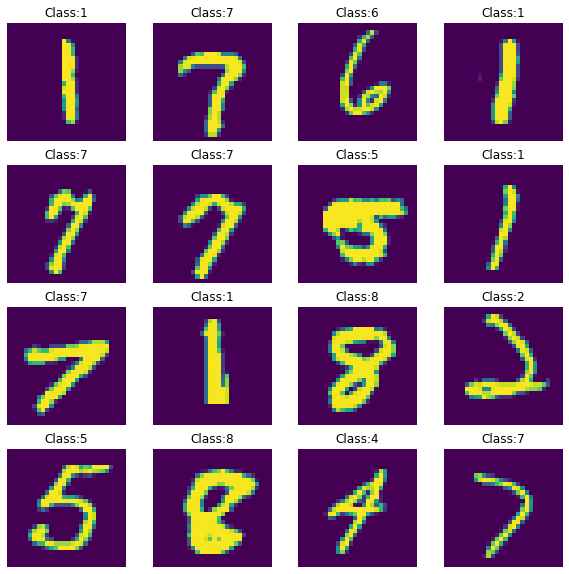

In [7]:
## 이미지들 비교
class_names = ['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  img = (img - img.min())/(img.max() - img.min())
  plt.imshow(torch.squeeze(img.permute(1, 2, 0)).numpy())
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

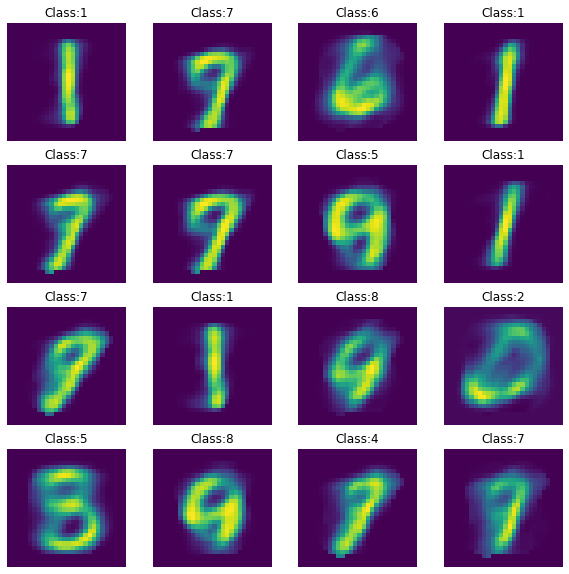

In [8]:
## 이미지들 비교
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  recon = model(img.view(-1, 28*28).to(gpu)).view((28,28)).cpu().detach().numpy()
  plt.imshow(recon)
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

어떤가요? 언뜻 보면 잘 복원하는것 같기도, 잘못 복원하는것 같기도 하는데 모델의 결과 만으로는 이러한 내용을 분석하기가 힘들어보입니다.

그렇다면 Input을 통해 생성된 latent space를 한번 시각화해서 확인해볼까요?

In [9]:
# 잠재변수를 3D 플롯으로 시각화
import pandas as pd
emb_train = pd.DataFrame()
for _, (data,label) in enumerate(tqdm(train_loader)):        
    x = data.view(-1, 28*28).to(gpu)
    emb = model.embedding(x)
    emb = pd.DataFrame(emb.cpu().detach().numpy(), columns = ["x","y","z"])
    emb["label"] = label.detach().numpy()
    emb_train = pd.concat([emb_train,emb],axis = 0, ignore_index = True)

100%|██████████| 1875/1875 [00:02<00:00, 666.36it/s]


In [19]:
emb_train["label"] = emb_train["label"].astype(str)
fig = px.scatter_3d(
    emb_train, x="x", y="y", z="z",
    color="label", labels={'color': 'cluster'}
)
fig.update_traces(marker_size=5)
fig.show()

다음과 같이 0,1,3에 대한 latent vector들은 분명하게 구분되는 반면, 그 외에 다른 숫자들은 latent들이 혼재되어 있는 것을 알 수 있습니다.

특히, 7과 9의 경우에는 latent들이 섞여있어 구분이 제대로 되지 않는 것을 알 수 있겠네요.

그렇다면, 다음 VAE 모델에서는 어떻게 latent space가 생성되는지 확인해볼까요?

---

### Variational autoencoder(VAE)
![image](https://www.researchgate.net/publication/333573656/figure/fig1/AS:765699362398208@1559568362329/Variational-AutoEncoder-VAE-architecture.png)

- VAE는 Generative model 이며 input 이 noise vector 가 아닌 이미지인 모델로 VAE의 궁극적인 목표는 모델을 통해서 생성된 이미지가 학습에 사용된 이미지 데이터셋에 대해 가지는 유사도를 가장 높일 수 있는 model parameters 를 학습하는 것입니다.
- 크게 encoder, decoder, 그리고 latent space로 구성된 구조를 가집니다.

#### 상세
- Encoder를 이용하여 입력값이 가지고 있는 평균과 분산을 추출하게 됩니다.
- 평균과 분산을 이용하여 Gaussian prior를 생성($p(z|x)$), prior에서 latent z를 추출합니다. ($q_ϕ(z|x)$)
- 추출된 z를 decoder를 통하여 입력한 x와 유사한 데이터를 생성합니다.($p(x)$)

#### ELBO

VAE는 생성된 이미지가 원래 이미지일 확률을 이용하여 학습을 합니다. 그러나 확률분포를 loss로 이용할 수는 없기 때문에 이를 근사시킨 값을 이용합니다. 이를 ELBO(Evidence Lower BOund)라 합니다.

(ELBO에 대해서 구체적인 설명은 Reference를 참고해주시면 되겠습니다.)

ELBO를 구성하는 요소로는 다음과 같습니다.

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbndyC4%2FbtqFA59BaZS%2FDLvwBkBvsuLDYuP8hfYXX1%2Fimg.png)

- Reconstruction term: 생성한 이미지와 input과의 비교를 위한 loss(BCE 혹은 MSE)
- Probability distance : latent distribution을 비교하는 KL-Divergence


In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder part, 
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc31 = nn.Linear(32, 3)
        self.fc32 = nn.Linear(32, 3)
        # decoder part
        self.fc4 = nn.Linear(3, 32)
        self.fc5 = nn.Linear(32, 128)
        self.fc6 = nn.Linear(128, 28*28)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

- Encoder에서는 input을 latent space로 변환하는 역할을 수행합니다. Input x를 학습한다면 latent vector z의 분포인 q(z|x)의 근사치를 찾는것을 목표로 합니다. 
- Decoder는 반대로 latent space를 input기반으로 변환하는 역할을 합니다. latent vector z 가 주어지면 q(z|x)의 근사치를 찾아 유사한 p(x|z)를 생성함을 목적으로 합니다. 즉. Input x와 유사한 latent 특성을 가진 이미지를 생성해주는것입니다. 
- autoencoder와 달리 VAE는 이 latent space를 기반으로 output을 만들긴 하지만, noise를 샘플링해 이를 이용해 latent space를 만든다는 차이가 있습니다.
- input x 를 generate하기 때문에, 모델에서 decoder가 Generative model의 역할을 하는것을 살펴볼 수 있습니다.

In [12]:
vae = VAE().to(gpu)
optimizer = torch.optim.Adam(vae.parameters(), lr = 1e-4, weight_decay=1e-4)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

VAE는 ELBO값을 loss로 학습하게 됩니다.

In [13]:
num_epochs = 20
for epoch in range(num_epochs):
    ## ============ Train ===============
    vae.train()
    train_loss = 0
    for _, (data,label) in enumerate(tqdm(train_loader)):
        
        data = data.to(gpu)
        # ===================forward=====================
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        train_loss += loss.cpu().detach().numpy()

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], Train loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/len(train_loader.dataset)))

  0%|          | 0/1875 [00:00<?, ?it/s]/home/choheeseung/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

100%|██████████| 1875/1875 [00:03<00:00, 495.71it/s]


epoch [1/20], Train loss:225.6412


100%|██████████| 1875/1875 [00:03<00:00, 490.52it/s]


epoch [2/20], Train loss:184.6641


100%|██████████| 1875/1875 [00:03<00:00, 501.31it/s]


epoch [3/20], Train loss:175.4948


100%|██████████| 1875/1875 [00:03<00:00, 499.99it/s]


epoch [4/20], Train loss:168.4892


100%|██████████| 1875/1875 [00:03<00:00, 498.02it/s]


epoch [5/20], Train loss:164.8690


100%|██████████| 1875/1875 [00:03<00:00, 491.11it/s]


epoch [6/20], Train loss:161.8497


100%|██████████| 1875/1875 [00:03<00:00, 502.29it/s]


epoch [7/20], Train loss:159.4494


100%|██████████| 1875/1875 [00:03<00:00, 500.53it/s]


epoch [8/20], Train loss:157.4694


100%|██████████| 1875/1875 [00:03<00:00, 491.98it/s]


epoch [9/20], Train loss:155.8820


100%|██████████| 1875/1875 [00:03<00:00, 504.84it/s]


epoch [10/20], Train loss:154.6164


100%|██████████| 1875/1875 [00:03<00:00, 491.63it/s]


epoch [11/20], Train loss:153.5691


100%|██████████| 1875/1875 [00:03<00:00, 491.74it/s]


epoch [12/20], Train loss:152.6768


100%|██████████| 1875/1875 [00:03<00:00, 495.74it/s]


epoch [13/20], Train loss:151.8976


100%|██████████| 1875/1875 [00:03<00:00, 502.15it/s]


epoch [14/20], Train loss:151.1588


100%|██████████| 1875/1875 [00:03<00:00, 504.07it/s]


epoch [15/20], Train loss:150.5062


100%|██████████| 1875/1875 [00:03<00:00, 498.66it/s]


epoch [16/20], Train loss:149.8609


100%|██████████| 1875/1875 [00:03<00:00, 495.79it/s]


epoch [17/20], Train loss:149.3142


100%|██████████| 1875/1875 [00:03<00:00, 493.87it/s]


epoch [18/20], Train loss:148.7489


100%|██████████| 1875/1875 [00:03<00:00, 501.45it/s]


epoch [19/20], Train loss:148.2197


100%|██████████| 1875/1875 [00:03<00:00, 495.29it/s]

epoch [20/20], Train loss:147.7135


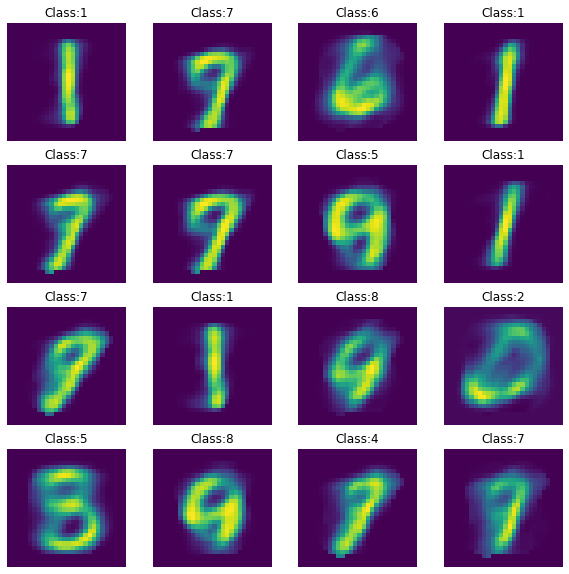

In [14]:
## 이미지들 비교
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  recon = model(img.view(-1, 28*28).to(gpu))[0].view((28,28)).cpu().detach().numpy()
  plt.imshow(recon)
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

VAE의 latent space도 시각화해서 확인해보겠습니다.

In [15]:
# 잠재변수를 3D 플롯으로 시각화
import pandas as pd
vae_train = pd.DataFrame()
for _, (data,label) in enumerate(tqdm(train_loader)):        
    x = data.view(-1, 28*28).to(gpu)
    mu, log_var = vae.encoder(x.view(-1, 784))
    z = vae.sampling(mu, log_var)    
    emb = pd.DataFrame(z.cpu().detach().numpy(), columns = ["x","y","z"])
    emb["label"] = label.detach().numpy()
    vae_train = pd.concat([vae_train,emb],axis = 0, ignore_index = True)

100%|██████████| 1875/1875 [00:02<00:00, 656.81it/s]


In [20]:
vae_train["label"] = vae_train["label"].astype(str)
fig = px.scatter_3d(
    vae_train, x="x", y="y", z="z",
    color="label", labels={'color': 'cluster'}
)
fig.update_traces(marker_size=5)
fig.show()

Autoencoder에서의 타원형과 같은 latent space와는 달리, VAE는 Gaussian prior로부터 latent를 추출하기 때문에 생성된 latent 역시 Gaussian 분포를 따르게 됩니다. 

또한, autoencoder에 비해 더 많은 데이터들이 구분되는 것을 확인할 수 있었습니다.

---

### 마치며

이번시간에는 1장에서 언급한 latent space를 학습하기 위하여 Autoencoder와 Variational autoencoder에 대해 학습하였습니다.

모델을 통해서 latent space가 학습되고, 의미 있는 latent가 표현되는 과정을 확인할 수 있었습니다.

다음 포스팅에서는 드디어 경도팀의 메인 주제인 GAN을 다뤄보도록 하겠습니다! GAN에서는 latent가 어떻게 형성되고, 이를 통해 어떻게 이미지를 생성해내는지 확인해보도록 하겠습니다!

감사합니다~

---

### Reference
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- Auto-Encoding Variational Bayes: https://arxiv.org/abs/1906.02691
- An Introduction to Variational Autoencoders: https://arxiv.org/abs/1906.02691
- 이활석(NAVER LAB), Autoencoder의 모든것
- VAE Code: https://github.com/lyeoni/pytorch-mnist-VAE